In [47]:

import numpy as np
import matplotlib.pyplot as plt 
import scipy

import sys
sys.path.append("/home/calab912/Documents/fdm-hybrid-scheme/")

import src.fd as fd 
import src.config as config
import src.animation as animation 
import demonstration.spectral_derivative as sd 

# Generate analytical solution for the 1D free Schrödinger equation
# Li test 1
def generate1DGaussian(x0, x, t, m = 1, hbar = 1, alpha=1.0 / 10):
    psi = np.sqrt(1 / (alpha + 1.0j * t * hbar/m)) * np.exp(
        -((x - x0) ** 2) / (2 * (alpha + 1.0j * t * hbar/m))
    )
    return psi

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=5, alpha= 1/20, eps=0, L=10, N=100):
    psi = eps + 0j
    N = 40
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

class Scheme:
    def __init__(self, config, generateIC):

        #print(f"Constructing {self.getName()} scheme")

        self.config              = config
        self.generateIC          = generateIC

        # Set up time management
        self.t0                  = config["t0"]
        self.t                   = config["t0"]
        self.dt                  = config["dt"]
        self.tEnd                = config["tEnd"]
        self.useAdaptiveTimestep = config["useAdaptiveTimestep"]
        self.outputTimestep      = config["outputTimestep"]
        self.timeOrder           = config["timeOrder"]
        self.cfl                 = config["cfl"]
        self.ntmax               = config["maximumNumberOfTimesteps"]



        # Set up grid (evenly-spaced with or without ghost boundary)
        self.dimension           = config["dimension"]
        self.stencilOrder        = config["stencilOrder"] 

        #Since we use np.roll for finite differences there is no need for a ghost boundary with periodic boundary conditions
        self.usePeriodicBC     = config["usePeriodicBC"]
        self.ghostBoundarySize = config["boundarySize"]

        self.useBC = config["useBC"]

        # Set up simulation grid
        N                = config["resolution"]
        self.L0, self.L1 = config["domainSize"]
        self.boxWidth  = self.L1 - self.L0 # physical box width

        self.innerN    = N
        self.dx        = self.boxWidth / (N - 1)

        #Handle ghost boundary
        self.totalN    = self.innerN + 2 * self.ghostBoundarySize
        N              = self.totalN
        Ll             = self.L0 - self.dx * self.ghostBoundarySize
        Lh             = self.L1 + self.dx * self.ghostBoundarySize
        self.PLMWidth  = Lh - Ll # PLM box width

        #Position of lower and upper grid boundary
        self.Ll = Ll 
        self.Lh = Lh 
        

        self.boundaryColumns = np.concatenate([np.arange(self.ghostBoundarySize), \
                                            np.arange(self.innerN + self.ghostBoundarySize, self.innerN + 2 * self.ghostBoundarySize)])
        self.innerColumns    = np.arange(self.ghostBoundarySize, self.innerN + self.ghostBoundarySize)


        self.boundary = np.ix_(self.boundaryColumns)
        self.inner    = np.ix_(self.innerColumns)

        #Create 1D grid
        xlin, self.dx = sd.computeX(self.Ll, self.Lh, self.totalN)
        self.grid = [xlin]

        self.debug = config["debug"]       
        self.hbar  = config["hbar"]
        self.m     = config["m"]
        self.eta   = self.hbar / self.m
        

        # Set up global parameters and constants
        self.G            = config["gravity"]
        self.useCosmology = config["useCosmology"]
        self.useHybrid    = False


        self.C_potential       = config["C_potential"]
        self.C_parabolic       = config["C_parabolic"]



        self.dt            = self.getTimeStep()
        
        self.psi           = self.generateIC(*self.grid, self.dx, self.t          , self.m, self.hbar)
        self.potential     = np.zeros(self.psi.shape)
        self.fields        = self.psi

        #Initialise buffer for fields at t - dt for leapfrog method
        self.old_fields    = self.generateIC(*self.grid, self.dx, self.t - self.dt, self.m, self.hbar)


    def getGrid(self):
        return self.grid

    def getTime(self):
        return self.t

    def getTimeStep(self): 
        if self.useAdaptiveTimestep:
            return self.getAdaptiveTimeStep()
        else:
            return self.dt 

    def getAdaptiveTimeStep(self):
        raise NotImplementedError("Please Implement this method")

    def getConfig(self):
        return self.config

    def getUpdatedFields(self, dt, fields):
        raise NotImplementedError("Please Implement this method")

    def setBoundaryConditions(self, fields):
        raise NotImplementedError("Please Implement this method")

    def getScaleFactor(self):
        return 1

    def run(self, tfin = None, enableBackward = False):
        if tfin is None:
            tfin = self.tEnd
        i = 0
        while(self.t < tfin - 1e-15):
            dt = self.getTimeStep()

            if (tfin - self.t < dt):
                dt = tfin - self.t

            self.step(dt)
            i += 1
            if i > self.ntmax:
                print("Maximum number of timesteps reached. Aborting.")
                break
        
        if enableBackward:
            while(tfin < self.t):
                dt = self.getTimeStep()

                if (self.t - tfin < dt):
                    dt = self.t - tfin

                self.step(-dt)
                i += 1
                if i > self.ntmax:
                    print("Maximum number of timesteps reached. Aborting.")
                    break
        print(f"Finished in {i} time steps")


    #Dummy function for implementation of first kick in kick-drift-kick scheme
    def kick1(self, fields, dt):
        return fields

    #Dummy function for implementation of second kick in kick-drift-kick scheme
    #Here the gravitational potential should be updated
    def kick2(self, fields, dt):
        return fields

    def getName(self):
        raise NotImplementedError("Please Implement this method")

    def getPotential(self):
        return self.potential

    def getScaleFactor(self):
        if self.useCosmology:
            return 1
        else:
            return 1

    def getPsi(self):
        return self.psi 

    def setPsi(self, psi):
        self.psi = psi 
        if self.G != 0:
            self.potential = self.computePotential(np.abs(self.psi)**2)

    def getDensity(self):
        return np.abs(self.psi) ** 2

    def getPhase(self):
        return fd.make_continuous(np.angle(self.psi))
        
    def getAdaptiveTimeStep(self):
        t1 = self.C_parabolic * self.dx**2/self.eta
        if self.G > 0:
            t2 = self.C_potential    * self.hbar/np.max(np.abs(self.potential) + 1e-8)
        else:
            t2 = 1e4
        
        return np.min([t1, t2])

    def setBoundaryConditions(self, psi, t):
        f = self.generateIC(*self.grid, self.dx, t, self.m, self.hbar)
        psi[self.boundary] = f[self.boundary]
        
    def computeRelErrorArray(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        return np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2) / (np.abs(psi_ref[self.inner])**2)
    
    def computeRelError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        l_infty_diff = np.max(np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2))
        l_infty_ref  = np.max(np.abs(psi_ref)**2)
        return l_infty_diff/l_infty_ref 


    def computeRMSError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        d1 = np.abs(self.psi[self.inner])**2
        d2 = np.abs(psi_ref[self.inner])**2
        RMS = np.sqrt(np.sum((d1 - d2)**2))
        RMS /= len(d1)
        return RMS
    

def multiply_along_axis(A, B, axis):
    return np.swapaxes(np.swapaxes(A, axis, -1) * B, -1, axis)


class GegenbauerDFTScheme(Scheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)
        self.debugWavefunction          = False 
        self.debugShiftfunction         = True

        self.alpha = config["alpha"]
        self.beta  = config["beta"]


    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi, self.t)
        else:
            self.psi[ :self.ghostBoundarySize] = np.roll(self.psi, 2*self.ghostBoundarySize)[:self.ghostBoundarySize]
            self.psi[-self.ghostBoundarySize:] = np.roll(self.psi,-2*self.ghostBoundarySize)[-self.ghostBoundarySize:]

        #Aliases
        x           = self.grid[0]
        psi         = self.psi
        dx          = self.dx
        N           = len(psi)
        
        Coeff1 = 1j * 1/2  * dt * self.eta


        #Length of hom. part of psi after evolution is len(psi) - 2*fd_boundary - x
        ksq             = self.getk(x)**2 
        fhat            = self.fft(self.psi)
        fhat            = fhat * np.exp(-ksq * Coeff1)
        g, lam          = self.fft2gegenbauer(fhat, self.alpha, self.beta) 

        #plt.title("Gegenbauer coefficients") 
        #plt.plot(g) 
        #plt.show() 
        
        self.psi        = self.igegenbauer(g, lam, self.shiftx(x))

        self.t += dt

    def getName(self):
        return "gegenbauer dft scheme"
 
    def getk(self, x): 
        N = int(len(x)/2)
        dx = x[1] - x[0]
        a  = x[0]
        b  = x[-1] + dx 
        return np.pi * np.concatenate([np.arange(0, N + 1),-np.flip(np.arange(1, N))]) / ((b - a)/2)

    def shiftx(self, x):
        dx = x[1] - x[0]
        a  = x[0]
        b  = x[-1] + dx 
        return  (x - (a + b)/2)/ ((b - a)/2)

    def fft(self, f):
        n = len(f)
        N = int(n/2)
        fhat = np.zeros( n, dtype=complex)
        for k in range( n ):
            #x-array in [-1, 1]
            x     = (-1 + np.arange(n) / N )
            waves = np.exp(- 1j * np.pi * k * x )
            #normalisation
            C     = 1/(2 * N) 
            fhat[k] = C * np.sum( f *  waves )

        return fhat

    def ifft(self, fhat):
        n = len(fhat)
        N = int(n/2)
        f = np.zeros( n, dtype=complex )
        for i, x in enumerate(-1 + np.arange(n) / N ):
            k     = np.arange( n )
            waves = np.exp(1j * np.pi * k * x )
            f[i]  = np.sum( fhat *  waves )

        return f

    def fft2gegenbauer(self, fhat, alpha, beta):
        # 1 (zero-mode) + 2N - 1 (N positive frequencies, N-1 negative frequencies)
        # since we cannot distinguish the Nth positive and Nth negative frequency we need to discard them
        n   = len(fhat)
        # number of positive frequencies
        N   = int(n/2)

        # Gegenbauer parameter lambda as function of N
        lam = int(alpha * N)
        # Number of terms in Gegenbauer expansion
        m   = int(beta  * N)

        # Gamma function 
        gam = scipy.special.gamma(lam)
        # Gegenbauer coefficients
        g   = np.zeros(m + 1, dtype=complex)

        # 2N - 1 (N positive frequencies, N-1 negative frequencies) 
        k      = np.concatenate([np.arange(1, N + 1),-np.flip(np.arange(1, N + 1))])
        fmat   = np.concatenate([fhat[1:N], [0, 0], fhat[N+1:]])


        for l in range( m + 1 ):  
            bessel = scipy.special.jv(l + lam, np.pi * k)
            coeff  = gam * bessel * (2 / (np.pi * k))**lam 
            g[l]   = (l == 0) * fhat[0] \
                    + (1j)**l * (l + lam) * np.sum(coeff * fmat)

        return g, lam

    def igegenbauer(self, g, lam, x): 
        n = len(x)
        f = np.zeros(x.shape, dtype=complex)
        for l, coeff in enumerate(g):
            f += coeff * scipy.special.eval_gegenbauer(l, lam, x)

        return f


1.032258064516129
1.032258064516129
[array([-0.19354839, -0.16129032, -0.12903226, -0.09677419, -0.06451613,
       -0.03225806,  0.        ,  0.03225806,  0.06451613,  0.09677419,
        0.12903226,  0.16129032,  0.19354839,  0.22580645,  0.25806452,
        0.29032258,  0.32258065,  0.35483871,  0.38709677,  0.41935484,
        0.4516129 ,  0.48387097,  0.51612903,  0.5483871 ,  0.58064516,
        0.61290323,  0.64516129,  0.67741935,  0.70967742,  0.74193548,
        0.77419355,  0.80645161,  0.83870968,  0.87096774,  0.90322581,
        0.93548387,  0.96774194,  1.        ,  1.03225806,  1.06451613,
        1.09677419,  1.12903226,  1.16129032,  1.19354839])]
Finished in 577 time steps
1.032258064516129
1.032258064516129
1.032258064516129
1.032258064516129


(0.014092358428973276, 0.012203587606260436)

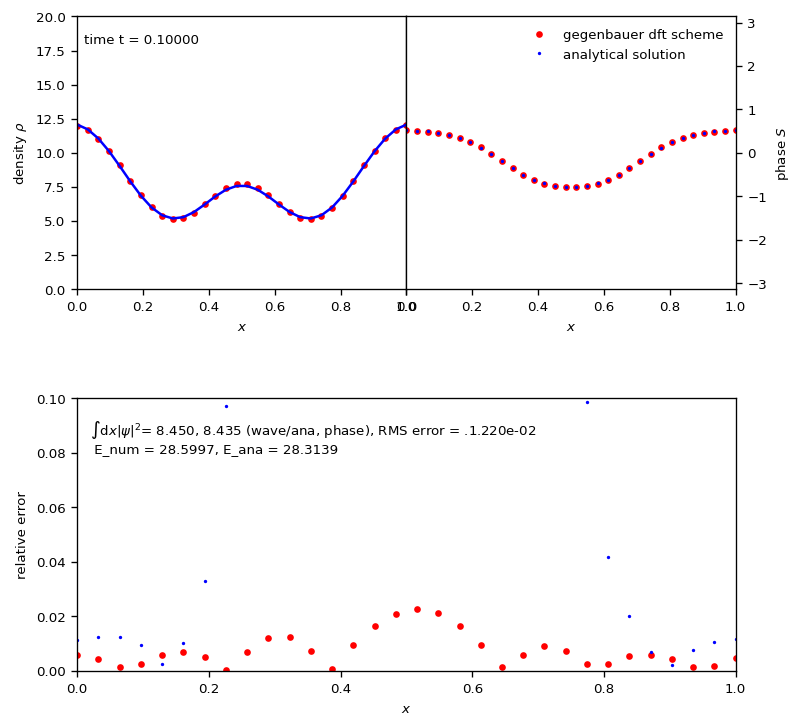

In [54]:

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=.5, alpha= 1/20, eps=0, L=1, N=100):
    psi = eps + 0j
    N = 40
    L = 1 + dx 
    print(L)
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 0.1
c["resolution"]                 = 32
c["boundarySize"]               = 6
c["useBC"]                      = False
c["domainSize"]                 = [0, 1]
c["xlim"]                       = [0, 1]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True
c["printGrid"]                  = False
c["alpha"]                      = 0.25
c["beta"]                       = 0.5
scheme = GegenbauerDFTScheme(c, periodic1DGaussian) 
print(scheme.grid)
scheme.debugShiftfunction = False
scheme.run()
animation.drawFrame(scheme)
scheme.computeRelError(), scheme.computeRMSError()